In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np


# Atenção : Para conseguir fazer esse trabalho tive que atualizar a versão do meu OpenCV para a versão 4.4.0
print(cv2.__version__)

4.4.0


# Leitura das imagens de entrada

Abaixo é realizada apenas a leitura das imagens de entrada e da imagem de referência.

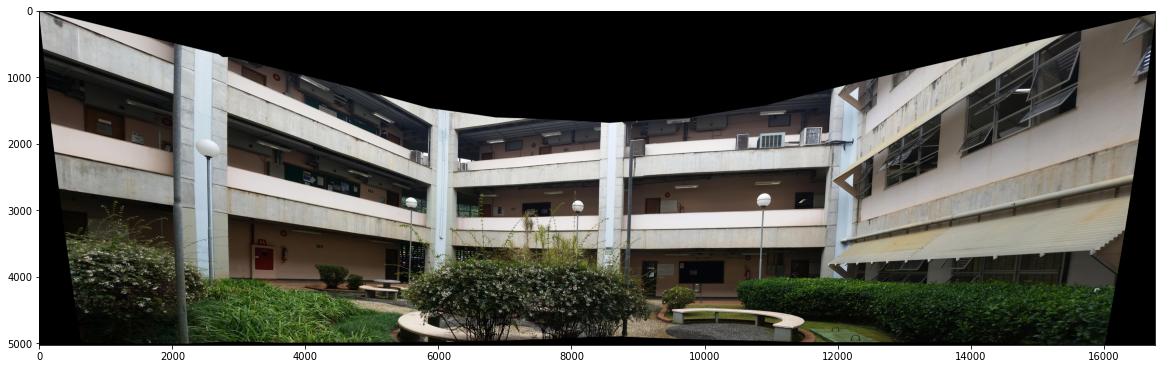

In [2]:
# Adiciona marcas nas bordas da imagem. Apenas usado para debug.
def add_color_marks(img):
    h, w, _ = img.shape
    cv2.circle(img,(0,0), 100, (0,0,255), -1)
    cv2.circle(img,(0,h), 100, (0,255,0), -1)
    cv2.circle(img,(w,0), 100, (255,0,0), -1)
    cv2.circle(img,(w,h), 100, (255,0,255), -1)


image_names = ['img1.jpg', 'img2.jpg', 'img3.jpg', 'img4.jpg', 'img5.jpg', 'img6.jpg']
imgs = []

for image_name in image_names:
    img = cv2.imread(image_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # add_color_marks(img)
    imgs.append(img)
    
ground_truth = cv2.imread('groundtruth.jpg')
ground_truth = cv2.cvtColor(ground_truth, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,10))
plt.imshow(ground_truth)

# Funções para busca de correspondência

As funções abaixo definem os três métodos de detecção e descrição dos pontos de interesse para busca de homografia.

<ul>
<li>SIFT</li>
<li>ORB</li>
<li>FAST+BRIEF</li>
</ul>

Todos as funções recebem como entrada duas imagens e retornam duas listas de pontos de correspondência (uma para cada imagem), sendo que em cada lista, o mesmo indice corresponde ao mesmo ponto em cada imagem.

In [3]:
def find_keypoint_pairs_sift(target, source):
    
    # Limito o número de key points para limitar o tempo de execução do algoritmo
    key_point_det = cv2.SIFT_create(nfeatures=2500)  
    
    kp_target, des_target = key_point_det.detectAndCompute(target,None)
    kp_source, des_source = key_point_det.detectAndCompute(source,None)
    
    # Utilizando o Flann na busca por correspondências para reduzir o tempo de execução
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary

    flann = cv2.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des_target,des_source, k=2)
    
    # Selecionando apenas os melhores matches
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)

    target_pts = np.float32([ kp_target[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    source_pts = np.float32([ kp_source[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    return target_pts, source_pts
    



In [4]:
def find_keypoint_pairs_orb(target, source):
    # Defino o número de key points para limitar o tempo de execução do algoritmo. O valor padrão é pequeno
    # e no caso aumentei o valor para ficar igual ao valor do FAST (próximo método)
    key_point_det = cv2.ORB_create(nfeatures=2500)
    
    kp_target, des_target = key_point_det.detectAndCompute(target,None)
    kp_source, des_source = key_point_det.detectAndCompute(source,None)

    # Por ser um descritor binário, utilizo a distância de HAMMING na busca das correspondências
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des_target,des_source)
    
    target_pts = np.float32([ kp_target[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
    source_pts = np.float32([ kp_source[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)
    return target_pts, source_pts




In [5]:
def find_keypoint_pairs_fast_brief(target, source):
    # Defino o valor do threshold do FAST. Caso este valor não seja definido, o número de keypoints encontrados é
    # muito elevado, levando a um tempo de execução muito grande. Com este threshold o número de key points
    # ficou em torno de 2500
    key_point_det = cv2.FastFeatureDetector_create(100)
    kp_target = key_point_det.detect(target, None)
    kp_source = key_point_det.detect(source, None)
    
    # Calculo os descritores com o BRIEF
    brief = cv2.xfeatures2d.BriefDescriptorExtractor_create(bytes=32)
    kp_target, des_target = brief.compute(target, kp_target)
    kp_source, des_source = brief.compute(source, kp_source)
    
    # Por ser um descritor binário, utilizo a distância de HAMMING na busca das correspondências
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des_target,des_source)
    
    target_pts = np.float32([ kp_target[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
    source_pts = np.float32([ kp_source[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)
    return target_pts, source_pts

# Cálculo da homografia

De acordo com o método de busca de correspondência selecionado, encontro os pontos de correspondência e entrego para a função de busca por homografia (que internamente utiliza o RANSAC para encontrar os melhores parâmetros).

A função retorna a matriz de homografia

In [6]:
def find_homography(target, source, method='orb'):
    if method == 'orb':
        target_pts, source_pts = find_keypoint_pairs_orb(target, source)
    elif method == 'sift':
        target_pts, source_pts = find_keypoint_pairs_sift(target, source)
    elif method == 'fast+brief':
        target_pts, source_pts = find_keypoint_pairs_fast_brief(target, source)
    else:
        raise 'Método não existente ou não implementado'
    
    H, mask = cv2.findHomography(target_pts, source_pts, cv2.RANSAC, 5.0)
    
    return H

# Funções de mescla de imagens

As funções abaixo são responsáveis por mesclar duas imagens. 3 estratégias foram implementadas.

<ul>
<li>Simples sobreposição - A imagem transformada é transferida primeiro e em seguida é transferida a segunda imagem. Pixels que se sobrepoem na imagem final recebem os valores da segunda imagem.</li>
<li>Média entre pixels - Na área onde ocorre sobreposição é calculada uma média entre os valores dos pixels das duas imagens naquela posição.</li>
<li>Feathering - Na area onde ocorre a sobreposição é ccalculada uma média poderada pela distancia de cada pixel em relação a borda da imagem original.</li>
</ul>



In [7]:
def simple_superposition(source, target):
    grey1 = cv2.cvtColor(source, cv2.COLOR_BGR2GRAY)
    _, mask1 = cv2.threshold(grey1, 1, 1, cv2.THRESH_BINARY)
    grey2 = cv2.cvtColor(target, cv2.COLOR_BGR2GRAY)
    _, mask2 = cv2.threshold(grey2, 1, 1, cv2.THRESH_BINARY)
    
    intersection = mask1 * mask2
        
    mask1 =  mask1 - intersection
    final = multiply_channels(source,mask1) + multiply_channels(target,mask2)
    
    return final
    

In [8]:
def multiply_channels(image, mask):
    ni = np.copy(image)
    ni[:,:,0] = image[:,:,0]*mask
    ni[:,:,1] = image[:,:,1]*mask
    ni[:,:,2] = image[:,:,2]*mask
    return ni


def straigh_averaging(image1, image2, w1, w2):
    grey1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    _, mask1 = cv2.threshold(grey1, 1, 1, cv2.THRESH_BINARY)
    grey2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    _, mask2 = cv2.threshold(grey2, 1, 1, cv2.THRESH_BINARY)
    
    intersection = mask1 * mask2
    disjunction = 1 - intersection
    
    mask1 = mask1*w1/(w1+w2) 
    mask2 = mask2*w2/(w1+w2)
    final = multiply_channels(image1,mask1) + multiply_channels(image2,mask2)
    
    ex1 = cv2.bitwise_and(image1, image1, mask=disjunction)
    ex2 = cv2.bitwise_and(image2, image2, mask=disjunction)
    mix = cv2.bitwise_and(final, final, mask=intersection)
    
    result = ex1 + ex2 + mix
    
    return result

In [9]:
def distance_matrix(shape):
    grid = np.indices((shape[0], shape[1]))
    top_left_borders = np.transpose(grid, (1,2,0))
    bottom_right_borders = np.flip(top_left_borders)
    top_left_distance = top_left_borders.min(axis=2)
    bottom_right_distance = bottom_right_borders.min(axis=2)
    distances = np.minimum(top_left_distance, bottom_right_distance)
    return np.float32(distances)


def feathering(image1, image2, distances1, distances2):
    grey1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    _, mask1 = cv2.threshold(grey1, 1, 1, cv2.THRESH_BINARY)
    grey2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    _, mask2 = cv2.threshold(grey2, 1, 1, cv2.THRESH_BINARY)
    
    intersection = mask1 * mask2
    disjunction = 1 - intersection
    distances_sum = distances1 + distances2
    
    mask1 = np.divide(mask1*distances1, distances_sum, out=np.zeros_like(distances_sum), where=distances_sum!=0)
    mask2 = np.divide(mask2*distances2, distances_sum, out=np.zeros_like(distances_sum), where=distances_sum!=0)
    
    final = multiply_channels(image1,mask1) + multiply_channels(image2,mask2)
    
    ex1 = cv2.bitwise_and(image1, image1, mask=disjunction)
    ex2 = cv2.bitwise_and(image2, image2, mask=disjunction)
    mix = cv2.bitwise_and(final, final, mask=intersection)
    
    result = ex1 + ex2 + mix
    
    return result
    
    

# Função para mescla de duas imagens

Abaixo temos as funções de mesclam duas imagens de acordo com as configurações selecionadas.

### get_new_image_params
A função 'get_new_image_params' é responsavel por descobrir os parâmetros da imagem final após receber a imagem transformada pela homografia. Como a imagem irá crescer, eventualmente, para unir as duas imagens, ambas terão que ser deslocadas (translação), assim essa função também retorna uma matrix de translação que posteriormente poderá ser usado para posicionar cada imagem corretamente na imagem final

### merge_images
A função 'merge_images' executa todos os passos para a junção das duas imagens. 
<ol>
<li>Calcula a homografia de acordo com o método selecionado,</li>
<li>Calcula a dimensão da imagem final (e o deslocamento necessário para posicinar cada imagem na imagem final,</li>
<li>Executa as transformações nas imagens, sendo que uma recebe a transformação da homografia + translação e a outra recebe apenas a translação,</li>
<li>Executa a mistura das duas imagens de acordo com o método selecionado.</li>
</ol>

In [10]:

def get_new_image_params(H, w_s, h_s, w_t, h_t):

    pts_s = np.float32([ [0, 0],[0, h_s],[w_s, h_s],[w_s,0] ]).reshape(-1,1,2)
    pts_t = np.float32([ [0, 0],[0, h_t],[w_t, h_t],[w_t,0] ]).reshape(-1,1,2)
    
    # Com os extremos da imagem de origem, verifico seus valores após a transformação perspectiva
    # relativa a matriz de homografia
    dst = np.array(cv2.perspectiveTransform(pts_s, H))
    
    # Junto os pontos extremos da imagem de origem após a transformação com os pontos da imagem original
    # após extrair os minimos e máximos consigo calcular as dimensões (altura e largura) e a translação
    # que será necessária para posicionar corretamente as duas imagens na imagem final (expandida)
    image_limits = np.concatenate( (pts_t, dst ) ).reshape(-1,2)
    max_limits = image_limits.max(axis=0)
    min_limits = image_limits.min(axis=0)
    new_dimensions = max_limits - min_limits
    translation = -min_limits
    T = np.array( [[1.0, 0.0, translation[0]], [0.0, 1.0, translation[1]], [0.0, 0.0, 1.0]] )

    return new_dimensions, T

In [11]:
def merge_images(target, source, method='orb', blend='averaging'):
    h_t, w_t, _ = target.shape
    h_s, w_s, _ = source.shape
    
    # Calcula a homografia
    H = find_homography(source, target, method)
    
    # Calcula as dimensões da imagem final
    new_dimension, T = get_new_image_params(H, w_s, h_s, w_t, h_t)
    new_dimension = (int(new_dimension[0]), int(new_dimension[1]))
    
    # Cria uma nova matriz de homografia aplicando adicionalmente a translação necessária para posicionar 
    # a imagem transformada na imagem final
    M = T.dot(H)
    warp_source = cv2.warpPerspective(source, M, new_dimension)
    
    # No caso da imagem destino, aplica apenas a translação, necessária para posicionar a imagem original 
    # na imagem final
    warp_target = cv2.warpPerspective(target, T, new_dimension)
    
    # Executa a mistura das imagens de acordo com o método selecionado
    if blend == 'feathering':
        source_distances = cv2.warpPerspective(distance_matrix(source.shape), M, new_dimension)
        target_distances = cv2.warpPerspective(distance_matrix(target.shape), T, new_dimension)
        result = feathering(warp_source, warp_target, source_distances, target_distances)
    elif blend == 'averaging':
        result = straigh_averaging(warp_source, warp_target, 1, 1)
    else:
        result = simple_superposition(warp_source, warp_target)

    return result



# Função para geração da imagem panoramica

A função abaixo é responsável por fazer a junção das imagens.

Ela começa juntando cada extremidade em separado (do extremo para o centro). No último passo junta os dois lados na imagem final.

In [12]:
def generate_panorama(imgs, method='orb', blend='averaging'):
    l0 = merge_images(imgs[1], imgs[0], method=method, blend=blend)
    r0 = merge_images(imgs[4], imgs[5], method=method, blend=blend)
    l1 = merge_images(imgs[2], l0, method=method, blend=blend)
    r1 = merge_images(imgs[3], r0, method=method, blend=blend)
    central = merge_images(l1, r1, method=method, blend=blend)
    
    return central

# Função para comparar imagens

A função 'compare_images' tem como objetivo comparar imagens após o a mescla. Como elas não necessáriamente estarão alinhadas, tambem para ela é necessário calcular a homografia de forma que eu possa encaixar o melhor possível uma sobre a outra e com isso calcular as diferenças.

Para calcular a diferença de cada pixel, primeiro eu calculo o erro quadrático para cada um dos canais de cor. Com isso terei, para cada pixel, um vetor cujo tamanho é proporcional a diferença entre as duas imagens naquele pixel. 

Para calcular a diferença no pixel eu verifico a norma deste vetor.

Como foi solicitado que na imagem de comparação o pixel receba um valor alto quando são muito similares, inverto a direção do valor.

In [13]:
def compare_images(target, source, method='orb'):
    h_t, w_t, _ = target.shape
    h_s, w_s, _ = source.shape
    
    H = find_homography(source, target, method)
    
    new_dimension, T = get_new_image_params(H, w_s, h_s, w_t, h_t)
    new_dimension = (int(new_dimension[0]), int(new_dimension[1]))
    
    M = T.dot(H)
    
    warp_source = cv2.warpPerspective(source, M, new_dimension)
    warp_target = cv2.warpPerspective(target, T, new_dimension)
    
    diff = np.sqrt(np.square(warp_target - warp_source)) # squared error for each color channel
    
    dist = np.linalg.norm(diff, axis=2).astype('uint8')  # the difference is the norm each pixel vector 
                                                         # (convert to an 1-dimensional image)
    max_dist = dist.max()
    if max_dist > 0:
        dist = (max_dist - dist)/max_dist                # Invert values. High pixel value means similar pixel.
    
    return dist

# Experimentos

Abaixo alguns experimentos demonstrando algumas caracteristicas dos algoritmos

## Funções de Blending

(3766, 7408, 3)


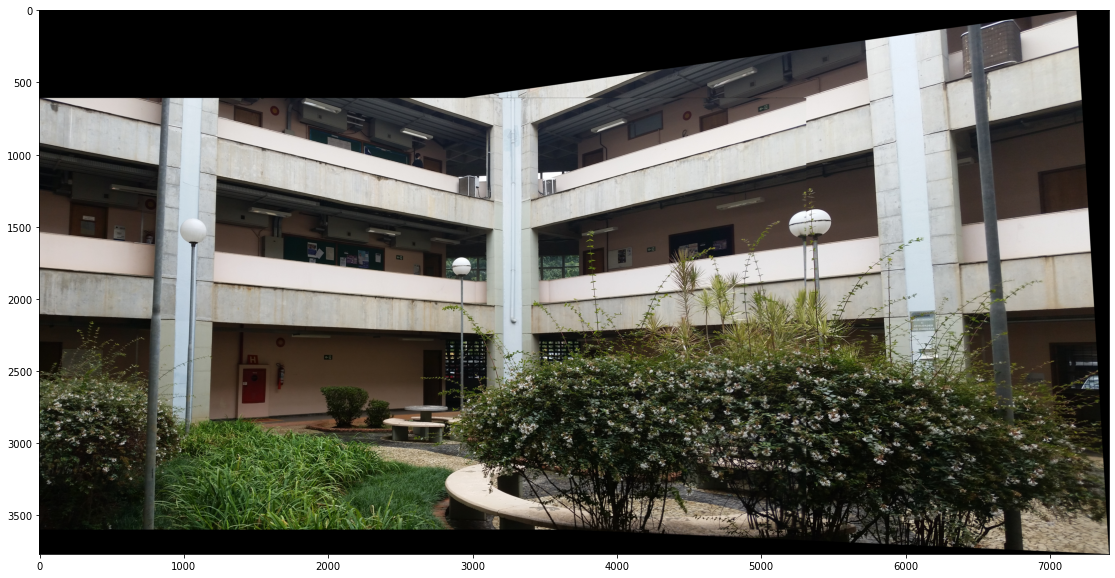

In [14]:
#Mescla simples

simple = merge_images(imgs[0], imgs[1], method='fast+brief', blend='simple')
    
plt.figure(figsize=(20,10))
plt.imshow(simple)
print(simple.shape)

(3766, 7408, 3)


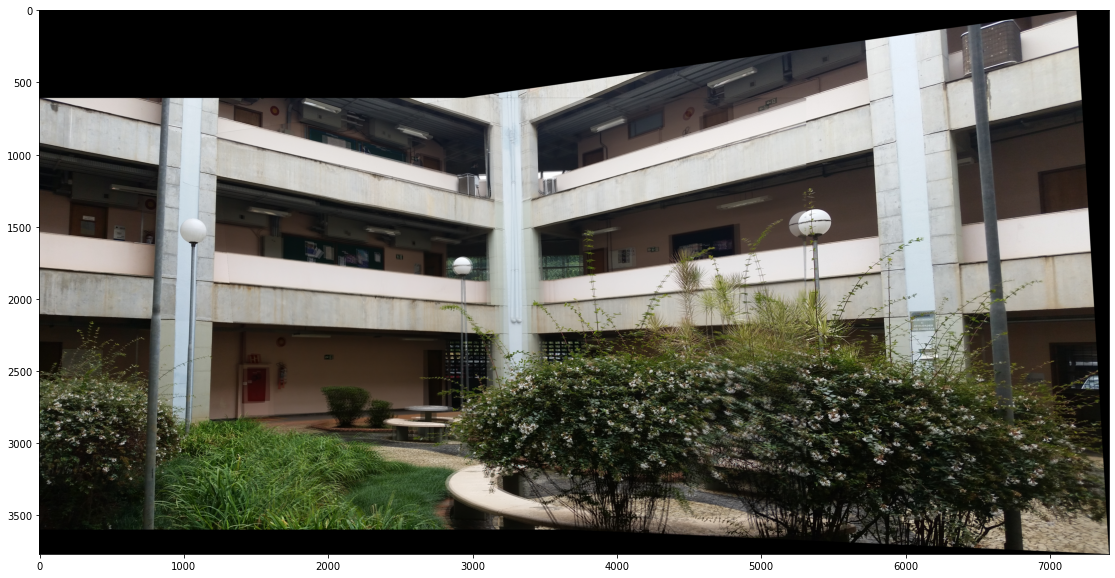

In [15]:
# Mescla utilizando valor médio das duas imagens

averaging = merge_images(imgs[0], imgs[1], method='fast+brief', blend='averaging')
  
plt.figure(figsize=(20,10))
plt.imshow(averaging)
print(averaging.shape)

(3766, 7408, 3)


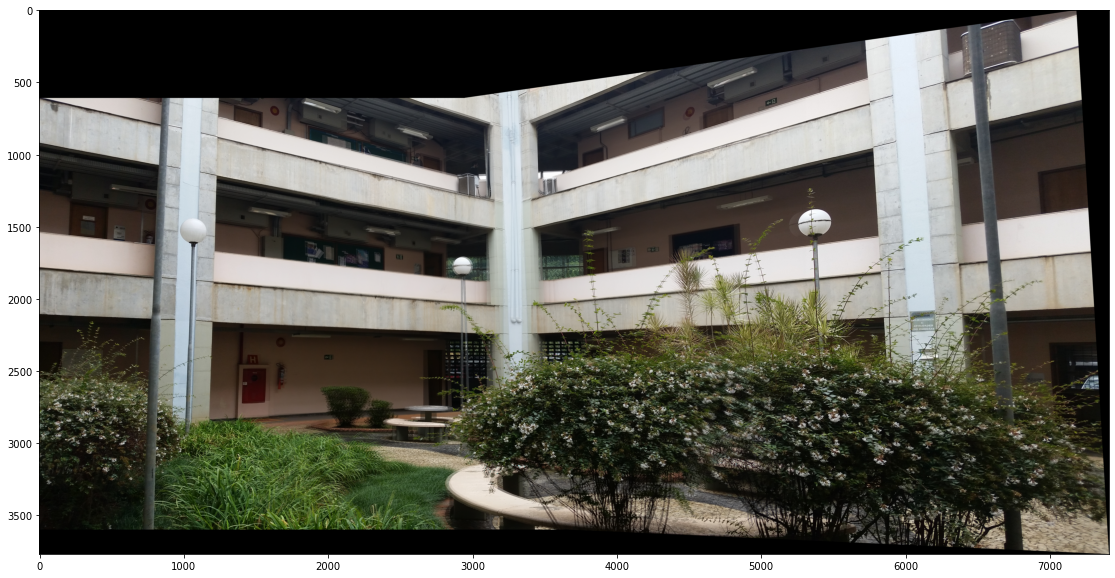

In [16]:
feather = merge_images(imgs[0], imgs[1], method='fast+brief', blend='feathering')

plt.figure(figsize=(20,10))
plt.imshow(feather)
print(feather.shape)

### Resultado

Abaixo podemos ver o resultado de cada um dos métodos observando o efeito sobre uma luminária que fica bem na junção entre as duas imagens.

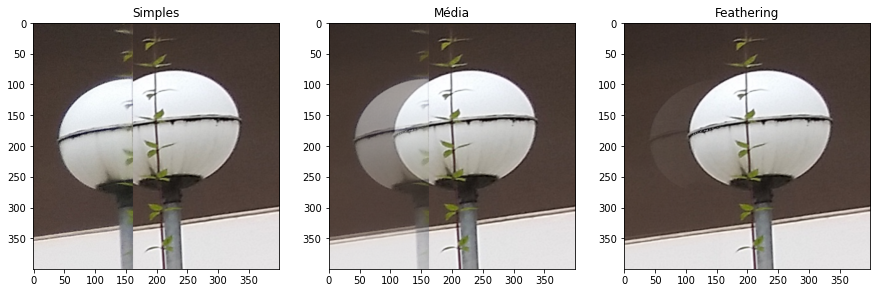

In [17]:

fig=plt.figure(figsize=(15, 15))
columns = 3
rows = 1
fig.add_subplot(rows, columns, 1)
plt.title('Simples')
plt.imshow(simple[1300:1700,5150:5550])

fig.add_subplot(rows, columns, 2)
plt.title('Média')
plt.imshow(averaging[1300:1700,5150:5550])

fig.add_subplot(rows, columns, 3)
plt.title('Feathering')
plt.imshow(feather[1300:1700,5150:5550])

plt.show()

## Função de comparação

Abaixo o resultado da comparação de duas imagens mescladas por métodos de busca por correspondência diferentes.

Áreas brancas representam pixels que possuem alta similaridade.

SME = 22277105.259259284


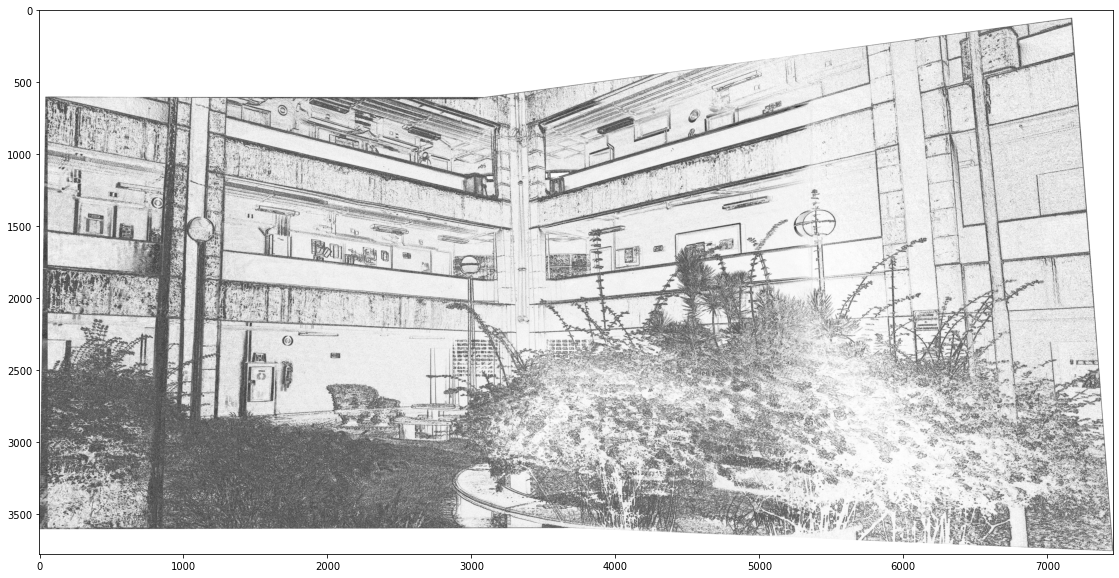

In [18]:

merge2 = merge_images(imgs[0], imgs[1], method='fast+brief', blend='feathering')
merge1 = merge_images(imgs[0], imgs[1], method='orb', blend='feathering')
comparisson = compare_images(merge1, merge2, method='fast+brief')
    
plt.figure(figsize=(20,10))
plt.imshow(comparisson, cmap='gray')

print('SME = {}'.format(comparisson.sum()))

## Geração das panorâmicas

In [19]:
panorama_orb = generate_panorama(imgs, method='orb', blend='feathering')
comparison_orb = compare_images(panorama_orb, ground_truth)

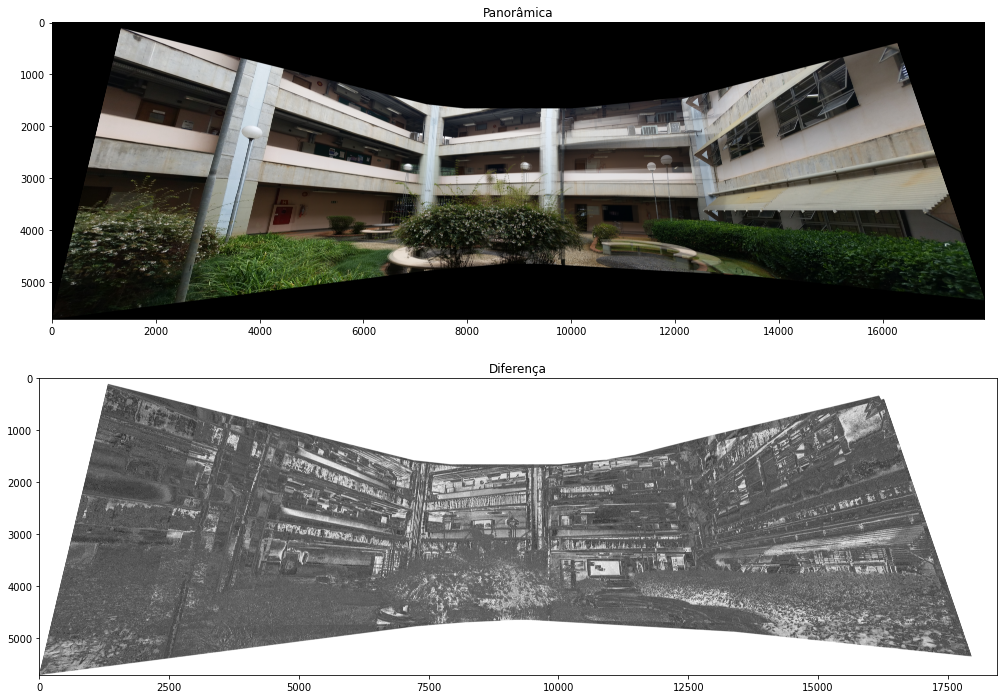

In [20]:
fig=plt.figure(figsize=(20, 12))
columns = 1
rows = 2
fig.add_subplot(rows, columns, 1)
plt.title('Panorâmica')
plt.imshow(panorama_orb)

fig.add_subplot(rows, columns, 2)
plt.title('Diferença')
plt.imshow(comparison_orb, cmap='gray')

plt.show()

In [21]:
panorama_sift = generate_panorama(imgs, method='sift', blend='feathering')
comparison_sift = compare_images(panorama_sift, ground_truth)

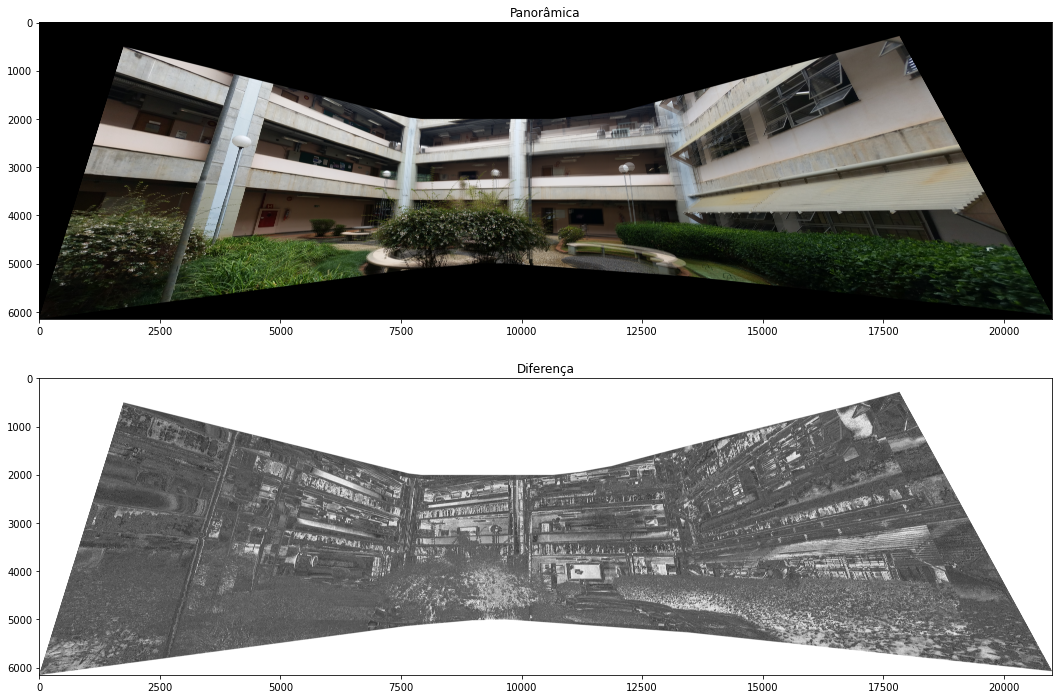

In [22]:
fig=plt.figure(figsize=(20, 12))
columns = 1
rows = 2
fig.add_subplot(rows, columns, 1)
plt.title('Panorâmica')
plt.imshow(panorama_sift)

fig.add_subplot(rows, columns, 2)
plt.title('Diferença')
plt.imshow(comparison_sift, cmap='gray')

plt.show()

In [23]:
panorama_fast_brief = generate_panorama(imgs, method='fast+brief', blend='feathering')
comparison_fast_brief = compare_images(panorama_fast_brief, ground_truth)

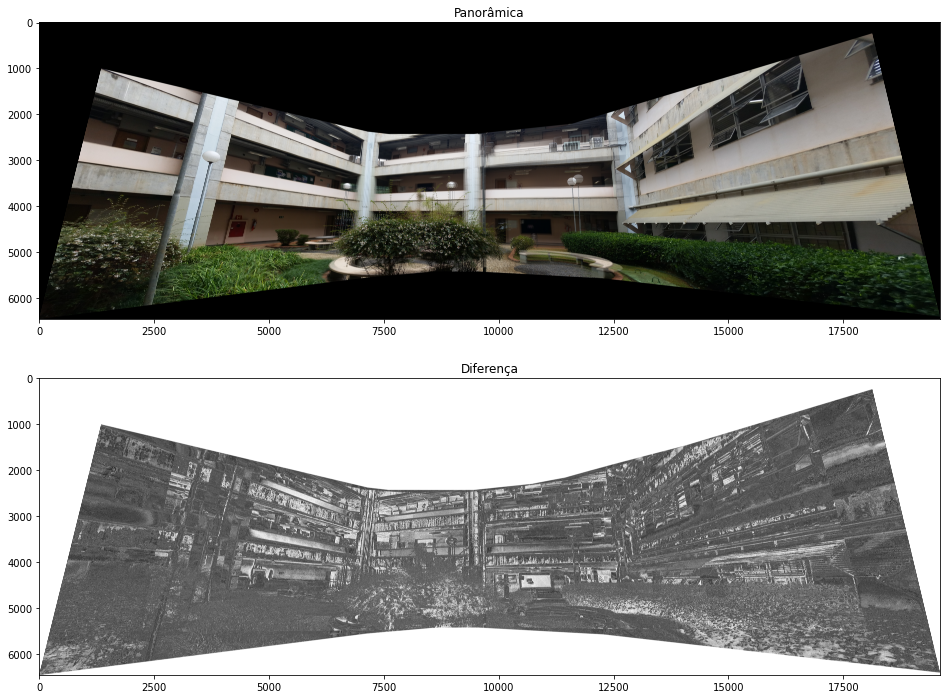

In [24]:
fig=plt.figure(figsize=(20, 12))
columns = 1
rows = 2
fig.add_subplot(rows, columns, 1)
plt.title('Panorâmica')
plt.imshow(panorama_fast_brief)

fig.add_subplot(rows, columns, 2)
plt.title('Diferença')
plt.imshow(comparison_fast_brief, cmap='gray')

plt.show()

# Atenção: os comandos abaixo são demorados

O objetivo deles é calcular as ponorâmicas utilizando diferentes métodos de busca de correspondência a mistura de imagens para, posteriormente, gerar um gráfico comparando.

In [25]:
panorama_fast_brief_av = generate_panorama(imgs, method='fast+brief', blend='averaging')
comparison_fast_brief_av = compare_images(panorama_fast_brief_av, ground_truth)

In [26]:
panorama_orb_av = generate_panorama(imgs, method='orb', blend='averaging')
comparison_orb_av = compare_images(panorama_orb_av, ground_truth)

In [27]:
panorama_sift_av = generate_panorama(imgs, method='sift', blend='averaging')
comparison_sift_av = compare_images(panorama_sift_av, ground_truth)

In [28]:
panorama_fast_brief_sml = generate_panorama(imgs, method='fast+brief', blend='simple')
comparison_fast_brief_sml = compare_images(panorama_fast_brief_sml, ground_truth)

In [29]:
panorama_orb_sml = generate_panorama(imgs, method='orb', blend='simple')
comparison_orb_sml = compare_images(panorama_orb_sml, ground_truth)

In [30]:
panorama_sift_sml = generate_panorama(imgs, method='sift', blend='simple')
comparison_sift_sml = compare_images(panorama_sift_sml, ground_truth)

In [31]:
labels = ['fast_brief', 'orb', 'sift']
simple = [comparison_fast_brief_sml.sum(), comparison_orb_sml.sum(), comparison_sift_sml.sum()]
averaging = [comparison_fast_brief_av.sum(), comparison_orb_av.sum(), comparison_sift_av.sum()]
feathering = [comparison_fast_brief.sum(), comparison_orb.sum(), comparison_sift.sum()]


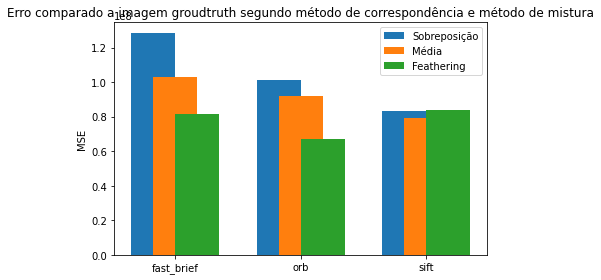

In [32]:
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, simple, width, label='Sobreposição')
rects2 = ax.bar(x , averaging, width, label='Média')
rects3 = ax.bar(x + width/2, feathering, width, label='Feathering')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MSE')
ax.set_title('Erro comparado a imagem groudtruth segundo método de correspondência e método de mistura')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

# Conclusão final

Conforme pode ser visto no gráfico acima, o SIFT na média apresentou o melhor resultado. 

A mistura de imagens utilizando o feathering apresentou os menores erros.